In [1]:
import torch
import numpy as np
import lightning as pl
import os
from typing import Optional
import torch.utils.data
import torchvision

In [2]:
class GTSRBDataModule(pl.LightningDataModule):
    def __init__(self, 
        data_dir:str='data',
        batch_size:int=32,
        size_val:float=0.1,
        manual_seed_train_val:int=42):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.size_val = size_val
        self.manual_seed_train_val = manual_seed_train_val
    def prepare_data(self):
          pass # à compléter
        
    def setup(self, stage: Optional[str] = None):
        if(stage=="fit") or stage is None:
             transf = torchvision.transforms.Compose([
                 torchvision.transforms.Resize((224,224)),
                 torchvision.transforms.RandomRotation(10),
                 torchvision.transforms.ToTensor()
                 ]
             )
             data_train = torchvision.datasets.ImageFolder(root=f"{self.data_dir}/train",transform=transf)
        if(stage == "test" or stage is None):
            transf = torchvision.transforms.Compose([
                 torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor()
                ]
             )
            self.data_test = torchvision.datasets.ImageFolder(root=f"{self.data_dir}/test",transform=transf)
        self.data_train, self.data_val = torch.utils.data.random_split(data_train,
        [len(data_train)-int(len(data_train)*self.size_val), int(len(data_train)*self.size_val)],
        generator=torch.Generator().manual_seed(self.manual_seed_train_val)
        )

        
    def train_dataloader(self):
          return torch.utils.data.DataLoader(self.data_train,batch_size=self.batch_size,shuffle=True)
    
    def val_dataloader(self):
          return torch.utils.data.DataLoader(self.data_val,batch_size=self.batch_size,shuffle=True)
    
    def test_dataloader(self):
          return torch.utils.data.DataLoader(self.data_test,batch_size=self.batch_size,shuffle=True)
    
    def predict_dataloader(self):
         return torch.utils.data.DataLoader(self.data_test,batch_size=self.batch_size,shuffle=True)


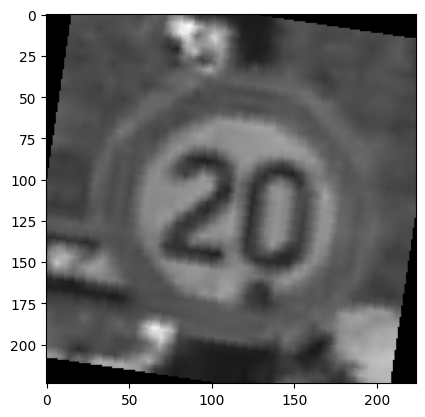

In [3]:
import matplotlib.pyplot as plt
gtsrb = GTSRBDataModule()
gtsrb.prepare_data()
gtsrb.setup()
d = next(iter(gtsrb.train_dataloader()))
plt.imshow(d[0][0,0],cmap='gray')
plt.show()

In [4]:
print(d[0].shape)

torch.Size([32, 3, 224, 224])


In [5]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn.functional as F
from torch import nn
from torchmetrics import Accuracy

class MyLightningModuleNet(pl.LightningModule):
    def __init__(self,
                 lr:float=0.1,
                 momentum:float=0.9,
                 weight_decay:float=1e-4,
                 num_class:int=4,#43,
                 *args, 
                 **kwargs
                ):
        super().__init__()
        self.modele = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.modele.fc = torch.nn.Linear(512,num_class)
        self.loss_train = torch.nn.CrossEntropyLoss()
        self.loss_val = torch.nn.CrossEntropyLoss()
        self.loss_test = torch.nn.CrossEntropyLoss()
        self.acc_val = Accuracy("multiclass",num_classes=num_class)
        self.acc_test = Accuracy("multiclass",num_classes=num_class)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.modele.forward(x)


    def training_step(self, batch:torch.Tensor, batch_idx: int):
          x,y = batch
          y_pred= self(x)
          loss = self.loss_train(y_pred,y)
          self.log("loss_train",loss)
          return loss
    
    def validation_step(self, batch:torch.Tensor, batch_idx):
        x,y = batch
        y_pred= self(x)
        loss = self.loss_val(y_pred,y)
        self.log("loss_val",loss)
        acc_val = self.acc_val(y_pred,y)
        self.log("accuracy_val", acc_val)

        
    
    def test_step(self, batch, batch_idx):
        x,y = batch
        y_pred= self(x)
        loss = self.loss_test(y_pred,y)
        acc_test = self.acc_test(y_pred,y)
        self.log("accuracy_test", acc_test)
        self.log("loss_test",loss)

        
    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), self.lr,self.momentum,self.weight_decay)
        return optim




In [6]:
trainer = pl.Trainer(max_epochs=4)
model = MyLightningModuleNet()
trainer.fit(model, train_dataloaders=gtsrb.train_dataloader(),val_dataloaders=gtsrb.val_dataloader())


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | modele     | ResNet             | 11.2 M | train
1 | loss_train | CrossEntropyLoss   | 0      | train
2 | loss_val   | CrossEntropyLoss   | 0      | train
3 | loss_test  | CrossEntropyLoss   | 0      | train
4 | acc_val    | MulticlassAccuracy | 0      | train
5 | acc_test   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/noahberneaud/Documents/portfolio/M1_Informatique/Apprentissage_Profond/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/noahberneaud/Documents/portfolio/M1_Informatique/Apprentissage_Profond/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/noahberneaud/Documents/portfolio/M1_Informatique/Apprentissage_Profond/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


In [7]:
trainer.validate(model, dataloaders=gtsrb.test_dataloader())

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      accuracy_val                  0.5
        loss_val             3.915698766708374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss_val': 3.915698766708374, 'accuracy_val': 0.5}]